In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from data import load_data
from utils import TRAINPATH, save_pickle, load_pickle, LANDMARK_DICT, DATAPATH
from plot import *
from pose import poses_for_dataset
import numpy as np
import mediapipe as mp
import pandas as pd
from tqdm import tqdm

mp_pose = mp.solutions.pose

In [3]:
shuffle = False

# Load the data
dataset, dataloader = load_data(path=TRAINPATH, batch_size=None, shuffle=shuffle, subset=False)

### Only need to run if you aren't loading from pickle

In [ ]:
# Do the pose estimation
estimated_poses, annotated_images = poses_for_dataset(dataloader)

In [ ]:
def pose_to_dataframe(estimated_poses, dataset, pose_var):
    all_val = []
    visib_val = []
    for_numpy = []
    for i in range(len(estimated_poses)):
        if estimated_poses[i]:
            val = []
            visib = []
            nump = []
            for land in getattr(estimated_poses[i], pose_var).landmark:
                x = land.x
                y = land.y
                z = land.z
                vis = land.visibility
                val.append([x,y,z,vis])
                nump.append([x,y,z])
                visib.append(vis)
            all_val.append(val)
            visib_val.append(visib)
            for_numpy.append(nump)
        else:
            all_val.append([None])
            visib_val.append([None])
            
    df = pd.DataFrame.from_records(all_val)
    df_vis = pd.DataFrame.from_records(visib_val)

    df = df.rename(LANDMARK_DICT, axis=1)
    df_vis = df_vis.rename(LANDMARK_DICT, axis=1)
    
    labels = []
    for _, label in dataset:
        labels.append(label)
    df['label'] = labels
    df_vis['label'] = labels
    
    labels_drop_na = np.array(df_vis.dropna(axis=0, how='any')['label'])
    
    return df, df_vis, np.array(for_numpy), labels_drop_na
    
# NOTE NUMPY DATA TAKES OUT NULLS, will have to take out nulls in labels
df, df_vis, numpy_data, labels_drop_na = pose_to_dataframe(estimated_poses, dataset, pose_var='pose_landmarks')
df_world, df_vis_world, numpy_data_world, _ = pose_to_dataframe(estimated_poses, dataset, pose_var='pose_world_landmarks')

In [ ]:
save_pickle(df, DATAPATH, "pose_landmark_all_df.pickle")
save_pickle(df_vis, DATAPATH, "pose_landmark_vis_df.pickle")
save_pickle(numpy_data, DATAPATH, "pose_landmark_numpy.pickle")
save_pickle(df_world, DATAPATH, "pose_world_landmark_all_df.pickle")
save_pickle(df_vis_world, DATAPATH, "pose_world_landmark_vis_df.pickle")
save_pickle(numpy_data_world, DATAPATH, "pose_world_landmark_numpy.pickle")
save_pickle(labels_drop_na, DATAPATH, "labels_drop_na.pickle")
save_pickle(annotated_images, DATAPATH, "annotated_images.pickle")

#### Otherwise can load from pickle

In [4]:
df = load_pickle(DATAPATH, "pose_landmark_all_df.pickle")
df_vis = load_pickle(DATAPATH, "pose_landmark_vis_df.pickle")
numpy_data = load_pickle(DATAPATH, "pose_landmark_numpy.pickle")
df_world = load_pickle(DATAPATH, "pose_world_landmark_all_df.pickle")
df_vis_world = load_pickle(DATAPATH, "pose_world_landmark_vis_df.pickle")
numpy_data_world = load_pickle(DATAPATH, "pose_world_landmark_numpy.pickle")
labels_drop_na = load_pickle(DATAPATH, "labels_drop_na.pickle")
annotated_images = load_pickle(DATAPATH, "annotated_images.pickle")

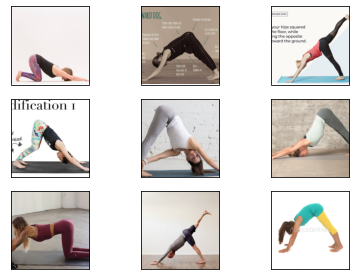

In [5]:
def plot_dataset_images(num):
    images, labels = [], []
    i = 0
    for image, label in dataset:
        i+=1
        images.append(image)
        labels.append(labels)
        if i >=num: break
    
    plot_image_grid(images, len(images), dataloader=True)
    
plot_dataset_images(9)

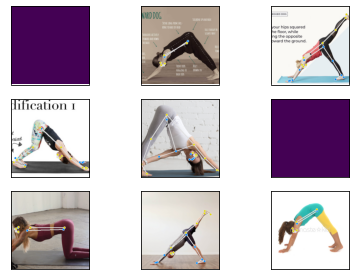

In [6]:
def plot_annotated_images(num):    
    annotated_plot = []
    for im in annotated_images:
        if im is None:
            annotated_plot.append([[0, 0], [0, 0]])
        else:
            annotated_plot.append(im)
    plot_image_grid(annotated_plot[:num], len(annotated_plot[:num]))
    
plot_annotated_images(9)

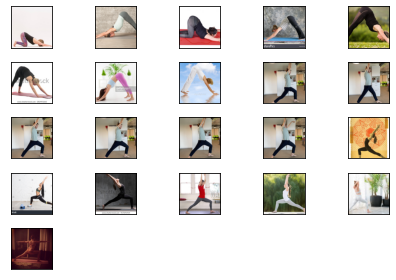

In [7]:
def plot_no_pose_photo(df, dataset, num=9):
    indx_null = df.index[df["NOSE"].isnull()].tolist()
    
    bad_photos = []
    i=0
    for ind in indx_null:
        if i>num: break
        bad_photos.append(dataset[ind][0])
        i+=1
        
    plot_image_grid(bad_photos, len(bad_photos), dataloader=True)
    
plot_no_pose_photo(df, dataset, 20)

In [8]:
print(f"There are {sum(df['NOSE'].isna())} images we don't get a pose estimate for out \
of {len(dataset)}. This is {sum(df['NOSE'].isna())/len(dataset)*100:.2f}%")

There are 71 images we don't get a pose estimate for out of 660. This is 10.76%


In [9]:
df_vis = df_vis.dropna(axis=0, how='any')

In [10]:
df_vis.describe()

,NOSE,LEFT_EYE_INNER,LEFT_EYE,LEFT_EYE_OUTER,RIGHT_EYE_INNER,RIGHT_EYE,RIGHT_EYE_OUTER,LEFT_EAR,RIGHT_EAR,MOUTH_LEFT,...,RIGHT_HIP,LEFT_KNEE,RIGHT_KNEE,LEFT_ANKLE,RIGHT_ANKLE,LEFT_HEEL,RIGHT_HEEL,LEFT_FOOD_INDEX,RIGHT_FOOT_INDEX,label
count,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,...,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000
mean,0.990984,0.986970,0.984939,0.988664,0.990829,0.991569,0.993774,0.991315,0.989233,0.985036,...,0.998652,0.638038,0.768771,0.681639,0.761392,0.719492,0.744411,0.707840,0.745456,1.054329
std,0.043073,0.054321,0.063897,0.048484,0.042867,0.044071,0.033069,0.046309,0.053258,0.063182,...,0.007248,0.404635,0.373063,0.366129,0.371747,0.309885,0.358920,0.329118,0.365325,0.855416
min,0.445070,0.363752,0.296410,0.382840,0.481808,0.481063,0.546340,0.335749,0.212925,0.144335,...,0.853793,0.000076,0.000045,0.000361,0.000059,0.000991,0.000466,0.000603,0.000122,0.000000
25%,0.995960,0.993641,0.993456,0.994727,0.995910,0.996911,0.997568,0.997278,0.996380,0.992867,...,0.999196,0.179368,0.777097,0.306375,0.735904,0.485372,0.698039,0.435897,0.661159,0.000000
50%,0.999646,0.999257,0.999278,0.999372,0.999524,0.999688,0.999651,0.999697,0.999619,0.999192,...,0.999850,0.890024,0.979095,0.907545,0.969175,0.888658,0.935964,0.890620,0.947833,1.000000
75%,0.999977,0.999938,0.999939,0.999944,0.999956,0.999968,0.999966,0.999975,0.999955,0.999944,...,0.999970,0.993490,0.995793,0.986490,0.992764,0.968436,0.981195,0.980344,0.986584,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.999999,0.999992,0.999997,0.999991,0.999986,0.999995,0.999998,0.999993,2.000000


In [11]:
df_vis.mean().sort_values(ascending=False)

label               1.054329
RIGHT_HIP           0.998652
LEFT_HIP            0.998636
LEFT_SHOULDER       0.998215
RIGHT_SHOULDER      0.996466
RIGHT_EYE_OUTER     0.993774
RIGHT_EYE           0.991569
LEFT_EAR            0.991315
NOSE                0.990984
RIGHT_EYE_INNER     0.990829
RIGHT_EAR           0.989233
LEFT_EYE_OUTER      0.988664
LEFT_EYE_INNER      0.986970
MOUTH_LEFT          0.985036
LEFT_EYE            0.984939
MOUTH_RIGHT         0.983104
RIGHT_KNEE          0.768771
RIGHT_ANKLE         0.761392
RIGHT_FOOT_INDEX    0.745456
RIGHT_HEEL          0.744411
LEFT_HEEL           0.719492
LEFT_FOOD_INDEX     0.707840
LEFT_ANKLE          0.681639
RIGHT_ELBOW         0.677358
LEFT_KNEE           0.638038
RIGHT_WRIST         0.632522
LEFT_INDEX          0.627704
RIGHT_PINKY         0.626845
LEFT_PINKY          0.626524
RIGHT_INDEX         0.624343
RIGHT_THUMB         0.609816
LEFT_ELBOW          0.609567
LEFT_THUMB          0.604711
LEFT_WRIST          0.588868
dtype: float64